In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import glob
import os
import sys
from collections import deque
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import yaml
import yamlordereddictloader

from torchvision import models
from yaml import dump
from dlrm.dlrm_s_pytorch import DLRM_Net, dash_separated_ints, dash_separated_floats
from ir.handlers import handlers
from ir.trace import trace
from ir.trace import get_backprop_memory
from utils.logger import create_logger
from utils.visualizer import plot_descent
from utils.visualizer import *

In [3]:
# import torch
# from torch.nn import Linear
# from torch_geometric.nn import GCNConv


# class GCN(torch.nn.Module):
#     def __init__(self):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(dataset.num_features, 4)
#         self.conv2 = GCNConv(4, 4)
#         self.conv3 = GCNConv(4, 2)
#         self.classifier = Linear(2, dataset.num_classes)

#     def forward(self, x, edge_index):
#         h = self.conv1(x, edge_index)
#         h = h.tanh()
#         h = self.conv2(h, edge_index)
#         h = h.tanh()
#         h = self.conv3(h, edge_index)
#         h = h.tanh()  # Final GNN embedding space.
        
#         # Apply a final (linear) classifier.
#         out = self.classifier(h)

#         return out, h

# from torch_geometric.datasets import KarateClub

# dataset = KarateClub()
# data = dataset[0] 
# model = GCN()

# _, h = model(data.x, data.edge_index)
# gnn_graph = trace(model, (data.x, data.edge_index))


## GAN 

In [4]:
# from __future__ import print_function
# import argparse
# import os
# import random
# import torch
# import torch.nn as nn
# import torch.nn.parallel
# import torch.backends.cudnn as cudnn
# import torch.optim as optim
# import torch.utils.data
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils


# parser = argparse.ArgumentParser()
# # parser.add_argument('--dataset', required=True, help='cifar10 | lsun | mnist |imagenet | folder | lfw | fake')
# # parser.add_argument('--dataroot', required=True, help='path to dataset')
# parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
# parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
# parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
# parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
# parser.add_argument('--ngf', type=int, default=64)
# parser.add_argument('--ndf', type=int, default=64)
# parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
# parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# parser.add_argument('--cuda', action='store_true', help='enables cuda')
# parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
# parser.add_argument('--netG', default='', help="path to netG (to continue training)")
# parser.add_argument('--netD', default='', help="path to netD (to continue training)")
# parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
# parser.add_argument('--manualSeed', type=int, help='manual seed')
# parser.add_argument('--classes', default='bedroom', help='comma separated list of classes for the lsun data set')

# opt = parser.parse_args([])
# print(opt)

# try:
#     os.makedirs(opt.outf)
# except OSError:
#     pass

# if opt.manualSeed is None:
#     opt.manualSeed = random.randint(1, 10000)
# print("Random Seed: ", opt.manualSeed)
# random.seed(opt.manualSeed)
# torch.manual_seed(opt.manualSeed)

# cudnn.benchmark = True

# device = torch.device("cuda:0" if opt.cuda else "cpu")
# ngpu = int(opt.ngpu)
# nz = int(opt.nz)
# ngf = int(opt.ngf)
# ndf = int(opt.ndf)
# nc = 3

# # custom weights initialization called on netG and netD
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         m.weight.data.normal_(0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)


# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
#             output = self.main(input)
#         return output


# netG = Generator(ngpu).to(device)
# netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))


# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
#             output = self.main(input)

#         return output.view(-1, 1).squeeze(1)


# netD = Discriminator(ngpu).to(device)
# netD.apply(weights_init)
# if opt.netD != '':
#     netD.load_state_dict(torch.load(opt.netD))

# criterion = nn.BCELoss()

# fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
# real_label = 1
# fake_label = 0

# # setup optimizer
# optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

# ############################
# # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
# ###########################
# # train with real
# netD.zero_grad()
# real_cpu = data[0].to(device)
# batch_size = real_cpu.size(0)
# label = torch.full((batch_size,), real_label, device=device)


# errD_real = criterion(output, label)


# D_x = output.mean().item()

# # train with fake
# noise = torch.randn(batch_size, nz, 1, 1, device=device)

# label.fill_(fake_label)

# errD_fake = criterion(output, label)

# D_G_z1 = output.mean().item()
# errD = errD_real + errD_fake
# optimizerD.step()

# ############################
# # (2) Update G network: maximize log(D(G(z)))
# ###########################
# netG.zero_grad()
# label.fill_(real_label)  # fake labels are real for generator cost

# errG = criterion(output, label)

# D_G_z2 = output.mean().item()
# optimizerG.step()

In [5]:
# graph1 = trace(netD, real_cpu)
# output = netD(real_cpu)
# errD_real.backward()
# graph2 = trace(netG, noise)
# fake = netG(noise)
# graph3 = trace(netD, fake.detach())
# output = netD(fake.detach())
# errD_fake.backward()
# output = netD(fake)
# graph4 = trace(netD, fake)
# errG.backward()

## Scheduling Class 

In [6]:
from generator import Generator, get_mem_props, get_compute_props
from generator import *
from utils.visualizer import *


In [7]:
import collections
import pdb

import numpy as np
import yaml
import yamlordereddictloader

from utils.logger import create_logger


class Scheduling:
    def __init__(self, hwfile="default.yaml"):
        base_dir = "configs/"
        self.total_cycles = 0
        self.technology = [1,1,40] 
        # maybe change this later to peripheral logic node or speed
#     [wire_cap , sense_amp_time, plogic_node],
        self.logger = create_logger("logs/stats.txt")
        self.config = self.create_config(
            yaml.load(open(base_dir + hwfile), Loader=yamlordereddictloader.Loader)
        )


In [8]:
def create_config(self, config):

    self.logger.info("Config Statistics : ")

    self.mle = config["memory_levels"]
    self.mem_energy = np.zeros((self.mle))
    self.compute_energy = 0
    self.mem_read_access = np.zeros((self.mle))
    self.mem_write_access = np.zeros((self.mle))
    self.mem_size = np.zeros((self.mle))
    self.mem_util = np.zeros((self.mle))
    self.mem_free = np.zeros((self.mle))
    self.mem_read_bw = np.zeros((self.mle))
    self.mem_write_bw = np.zeros((self.mle))
    self.internal_bandwidth_time = 0
    self.total_cycles = 0 
    self.bandwidth_idle_time = 0
    self.compute_idle_time = 0
    self.mem_size_idle_time = 0

    self.force_connectivity = False
    mm_compute = config["mm_compute"]
    vector_compute = config["vector_compute"]

    if config["mm_compute"]["class"] == "systolic_array":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"]) ** 2) * mm_compute["N_PE"] / (2*4)
        )
        config["comp_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

        self.logger.info(
            "MM Compute per cycle : %d", config["mm_compute_per_cycle"]
        )
        self.logger.info("Compute Bandwidth Required : %d", config["comp_bw"])

    if config["mm_compute"]["class"] == "mac":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"])) * mm_compute["N_PE"] / 2
        )
        config["comp_read_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

    for i in range(self.mle):
        memory = config["memory"]["level" + str(i)]
        self.mem_read_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["read_ports"]
            * memory["width"]
        )
        self.mem_write_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["write_ports"]
            * memory["width"]
        )
        self.mem_size[i] = memory["size"]
        
        self.logger.info(
            "Memory at Level %d, Read Bandwidth %d Write Bandwidth %d",
            i,
            self.mem_read_bw[i],
            self.mem_write_bw[i],
        )
    for i in range(self.mle - 1):
        memory = config["memory"]["level" + str(i)]
        read_energy, write_energy, leakage_power = get_mem_props(
            memory["size"], memory["width"], memory["banks"]
        )
        config["memory"]["level" + str(i)]["read_energy"] = str(read_energy)
        config["memory"]["level" + str(i)]["write_energy"] = str(write_energy)
        config["memory"]["level" + str(i)]["leakage_power"] = str(leakage_power)
    return config

## Runner Function

In [9]:
def run(self, graph):

    """
     Check both size, utilization and bandwidths at every node
     What about memory size that can also get exhausted ?
     So if memory size is exhausted, then have to go to a previous level and write there ?
     if any level utilization is exhausted then only the immediate memory required will be kept.
     if the memory is empty in size, but is not bandwidth, it is useless?
     Cannot do prefetching
     Read access of the next node will decrease
     Bandwidth is available but size is not?, can do prefetching, but now the memory fetches have to check, 
     whether to do fetches of the same node or a different node
     Say bandwidth at level0 is sufficient, at level1 is insufficient, then at level1 we have a bottlenecks
     slower so it will take its own time
     Do vector operations in the meantime perhaps ? 

    """

    config = self.config

    read_bw_req = []
    write_bw_req = []
    read_bw_actual = []
    write_bw_actual = []
    cycles = []
    free_cycles = []
    transferable_checkpointed_edge = []
    all_checkpointed_edge = []
    self.mem_util_log=[]
    self.mem_util_full=[]
    # Mem Fetch time of the last Nodes
#     print(self.mem_free[0], self.mem_util[0], self.mem_size[0])

    mem_free = True
    for n, node in enumerate(graph.nodes):

        # These are last level read/write accesses
        compute_expense, weights = node.get_stats()
        read_access = node.mem_fetch
        write_access = 0
        self.mem_read_access[1]+=(weights)
        
        self.mem_util[0] += node.in_edge_mem
        node.mem_util = node.out_edge_mem + node.mem_fetch
        # Total Free memory
        for i in range(self.mle - 1):
            self.mem_free[i] = self.mem_size[i] - self.mem_util[i]
            
#         print("2",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        time_compute = compute_expense / config["mm_compute_per_cycle"]
        read_bw_ll = read_access / (time_compute)
        write_bw_ll = write_access / (time_compute)
        step_cycles = time_compute
        read_bw_req.append(read_bw_ll)
        write_bw_req.append(write_bw_ll)
        free_cycles.append(step_cycles)
#         print("bandwidth",read_bw_ll, write_bw_ll, step_cycles) 
        
        if self.mem_free[0] < node.mem_util:
            mem_free = False
            # node mem_util = output edge
            self.logger.info("Memory size is too low/ Memory is Full")
            self.logger.info("Node or Node memory Requirements too high")
            # Rearrange the checkpointed_nodes
            # rearrange = True

            # Is it possible now : Otherwise update the last level memory bandwidth requirements
            assert (self.mem_free[0]+node.in_edge_mem)>0
            # Change this later with the number of solid total cycles
            used_pe_ratio = (self.mem_free[0]+node.in_edge_mem)/(node.mem_util+node.in_edge_mem)
            n_swaps = int(1/used_pe_ratio+1)
            swap_time = max(config["mm_compute"]["size"]*4,time_compute//n_swaps)
            self.mem_size_idle_time += swap_time*n_swaps + (node.mem_util+node.in_edge_mem)//self.mem_read_bw[self.mle-1] 
            step_cycles+=self.mem_size_idle_time
            self.mem_read_access[0]+=(node.mem_util+node.in_edge_mem)
            self.mem_write_access[0]+=(node.mem_util+node.in_edge_mem)
        else:
            self.mem_util[0] += node.mem_util
            self.mem_free[0] -= node.mem_util
#         print("2.5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        self.mem_util_log.append(self.mem_util[0])
        self.mem_read_access[0]+=node.weights+node.out_edge_mem
        self.mem_write_access[0]+=node.weights+node.out_edge_mem
        assert(self.mem_free[0] < self.mem_size[0])
        # Last level memory fetch takes more time, so that may be a bottleneck
        bandwidth_available = read_bw_ll < self.mem_read_bw[self.mle - 1]
        
        # If Bandwidth is not available : Cannot Prefetch
        if (bandwidth_available) == False:
            step_cycles += (
                read_bw_ll / self.mem_read_bw[self.mle - 1]
            - 1) * time_compute
            self.bandwidth_idle_time += (
                read_bw_ll / self.mem_read_bw[self.mle - 1]
            - 1) * time_compute

        # If memory is not free for the next node and Bandwidth is available : Move nodes back and forth
        # if(total_mem_free[0] == 0 and (bandwidth_available)):
        # for(nodes in checkpointed_nodes):
        # checkpointed but not immediate node

        # Check if memory is free and Bandwidth available : From the Data Dependence Graph, Prefetch new node

        # pdb.set_trace()
        if self.mem_free[0] > 0 and (bandwidth_available):
            if n < len(graph.nodes) - 1:
                if self.mem_free[0] > node.next.mem_fetch:
                    read_access += node.next.mem_fetch
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        self.mem_util[0] += node.next.mem_fetch
                        self.mem_free[0] -= node.next.mem_fetch
                        node.next.mem_fetch = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_fetch = read_access - read_bw_ll * step_cycles

                else:
                    read_access += self.mem_free[0]
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        node.next.mem_fetch = node.next.mem_fetch - self.mem_free[0]
                        self.mem_util[0] = self.mem_size[0]
                        self.mem_free[0] = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_fetch = read_access - read_bw_ll * step_cycles
#         print("3",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        self.mem_util_full.append(self.mem_util[0])   
        
            # TODO Consider Write bandwidth for a block read memory or Write Bandwidth  for a endurance purposes
        self.mem_util[0] -= node.in_edge_mem
#         print("4",self.mem_free[0], self.mem_util[0], self.mem_size[0])
    
        if mem_free:
            self.mem_util[0] -= node.mem_util
#         print("5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        
        self.logger.info(
            "Node operator %r, Step Cycles %d, Read Accesses %d, Write Accesses %d ",
            node.operator,
            step_cycles,
            read_access,
            write_access,
        )
        self.total_cycles += step_cycles
        cycles.append(step_cycles)
        read_bw_actual.append(read_access / step_cycles)
        write_bw_actual.append(write_access / step_cycles)
#         print("actual",read_access / step_cycles, write_access / step_cycles, step_cycles)
#     print("The total cycles are ", self.total_cycles)
    return read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles

In [10]:
Scheduling.create_config = create_config
Scheduling.run = run

## Runner Forward and Runner Functions 

In [11]:
def runner_forward(graph_set):
    """
    Runs the Input Graph
    """ 
    generator = Generator()
    bandwidth = [2,10,50,75,100]
    num_iterations = 50
    for graph in graph_set:
#     for i in range(len(bandwidth)):
        scheduler = Scheduling()
#         scheduler.mem_read_bw[1] = 10*bandwidth[i]
        read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
        read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
#         bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)
#         cycles_bar_graph("cycles.png", cycles, free_cycles, graph.nodes)
#         mem_util_bar_graph("mem_util.png",scheduler.mem_util_full/scheduler.mem_size[0],scheduler.mem_util_log/scheduler.mem_size[0], graph.nodes)
#         in_time, in_energy, design, tech = generator.save_stats(scheduler)
        in_time, in_energy, design, tech = generator.save_stats(scheduler, True, get_backprop_memory(graph.nodes))
        print("======Optimizing Design and Connectivity=========")
        for i in range(num_iterations):
            config = generator.backward_pass(scheduler)
            generator.writeconfig(config, str(i) + "hw.yaml")
            scheduler.create_config(config)
            _,_,_,_, cycles, free_cycles = scheduler.run(graph)
#             time, energy, design, tech = generator.save_stats(scheduler)
            time, energy, design, tech = generator.save_stats(scheduler, True, get_backprop_memory(graph.nodes))
        print(in_time[0]//time[0], in_energy[0]//energy[0])
        print("===============Optimizing Technology=============")
        for i in range(10):
            config = generator.backward_pass_tech(scheduler,"time")
            generator.writeconfig(config, str(i) + "hw.yaml")
            scheduler.create_config(config)
            _,_,_,_, cycles, free_cycles = scheduler.run(graph)
#             time, energy, design, tech = generator.save_stats(scheduler)
            time, energy, design, tech = generator.save_stats(scheduler, True, get_backprop_memory(graph.nodes))
        print(in_time[0]//time[0], in_energy[0]//energy[0])
     



In [12]:
from models import vggnet_graph, resnet_graph, bert_graph, gpt2_graph, dlrm_graph
print("=====================================VGG-Net=============================================")
vgg11_graph = vggnet_graph()
# runner_forward([vgg11_graph])
# print("=====================================ResNet===============================================")

# runner_forward([resnet_graph])
# dlrm_graph = dlrm_graph()
# runner_forward([dlrm_graph])
# runner_forward([gnn_graph])
# runner_forward([dart_graph])
# bert_graph = bert_graph()
# runner_forward([bert_graph])
# runner_forward([gpt2_graph])
# runner_forward([a3c_graph]) # Actor Critic
# runner_forward([gan_graph]) 

=====================================VGG-Net=============================================


In [13]:
def runner(graph_set, scheduler):
    """
    Runs the Input Graph
    """ 
    time_list = []
    energy_list=[]
    bandwidth_time_list = []
    mem_size_idle_time_list=[]
    bank_list=[]
    mem_size_list=[]
    compute_list=[]
    tech_params_list = []
    num_iterations = 6
    generator = Generator()
    bandwidth = [2,10,50,75,100]
    for graph in graph_set:
#     for i in range(len(bandwidth)):
#         scheduler.mem_read_bw[1] = 10*bandwidth[i]
        read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
        read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
#         bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)
#         cycles_bar_graph("cycles.png", cycles, free_cycles, graph.nodes)
#         mem_util_bar_graph("mem_util.png",scheduler.mem_util_full/scheduler.mem_size[0],scheduler.mem_util_log/scheduler.mem_size[0], graph.nodes)
#         generator.save_statistics(scheduler, True, get_backprop_memory(graph.nodes))
        time, energy, design, tech = generator.save_stats(scheduler)
        time_list.append(time[0])
        energy_list.append(energy[0])
        bandwidth_time_list.append(time[1])
        mem_size_idle_time_list.append(time[2])
        bank_list.append(design[0])
        mem_size_list.append(design[1])
        tech_params_list.append(tech)
        #         print(scheduler.config)
        for i in range(num_iterations):
            config = generator.backward_pass(scheduler, "time")
            generator.writeconfig(config, str(i) + "hw.yaml")
            scheduler.create_config(config)
            read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
#             read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
# #             bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes, cycles)
            time, energy, design, tech = generator.save_stats(scheduler)
            time_list.append(time[0])
            energy_list.append(energy[0])
            bandwidth_time_list.append(time[1])
            mem_size_idle_time_list.append(time[2])
            bank_list.append(design[0])
            mem_size_list.append(design[1])
            tech_params_list.append(tech)
        return [time_list, bandwidth_time_list, mem_size_idle_time_list, bank_list, mem_size_list, compute_list, tech_params_list]


## Plot Descent

Time 11343262 425921 0 1963935
Energy 3769136556 3740661199 6769133 5412533 2828260 2657877 0 11343262
memory accesses 177326387 177326387 11343262 132893864
Design Params 2 1000000 1000 0.0381733
Tech Params [1, 1, 40]
Time 11252500 425921 0 1948808
Energy 3737310229 3709061501 6757584 5403299 2805630 2657877 0 11252500
memory accesses 177023853 177023853 11252500 132893864
Design Params 2 1003462 1000 0.0381733
Tech Params [1, 1, 40]
Time 11233424 425921 0 1945202
Energy 3730799356 3702598259 6755219 5401408 2800874 2657877 0 11233424
memory accesses 176961907 176961907 11233424 132893864
Design Params 2 1006925 1000 0.0381733
Tech Params [1, 1, 40]
Time 11233168 425921 0 1944946
Energy 3730798718 3702598259 6755219 5401408 2800810 2657877 0 11233168
memory accesses 176961907 176961907 11233168 132893864
Design Params 2 1010388 1000 0.0381733
Tech Params [1, 1, 40]
Time 11233168 425921 0 1944946
Energy 3730798718 3702598259 6755219 5401408 2800810 2657877 0 11233168
memory accesses 1

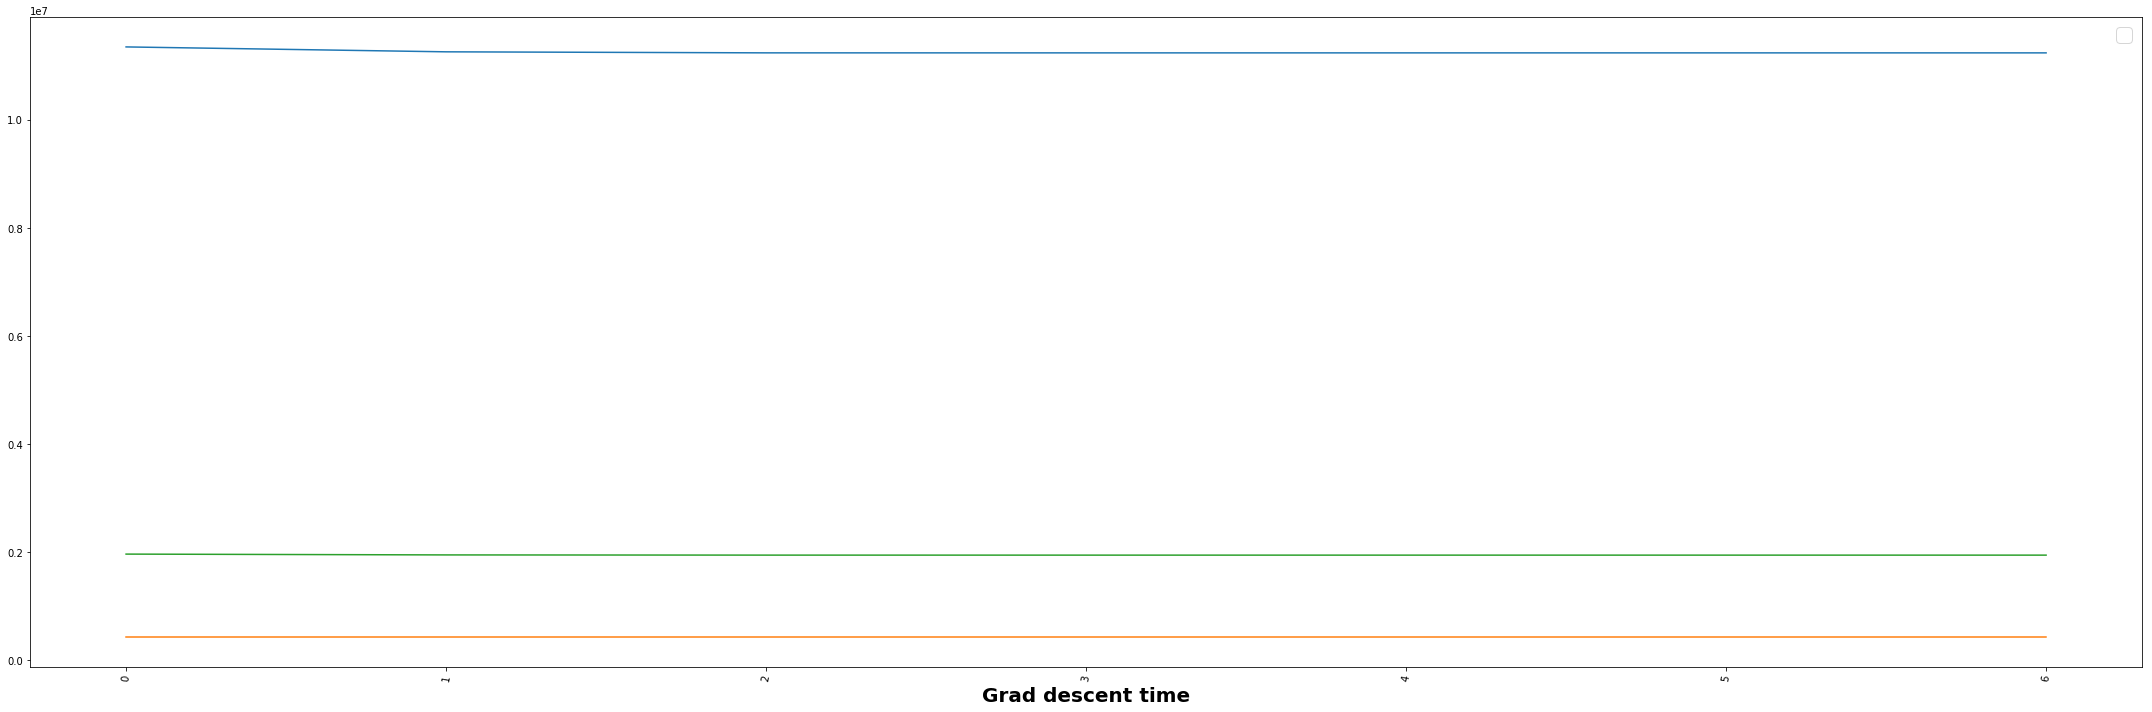

[[1, 1, 40], [1, 1, 40], [1, 1, 40], [1, 1, 40], [1, 1, 40], [1, 1, 40], [1, 1, 40]]


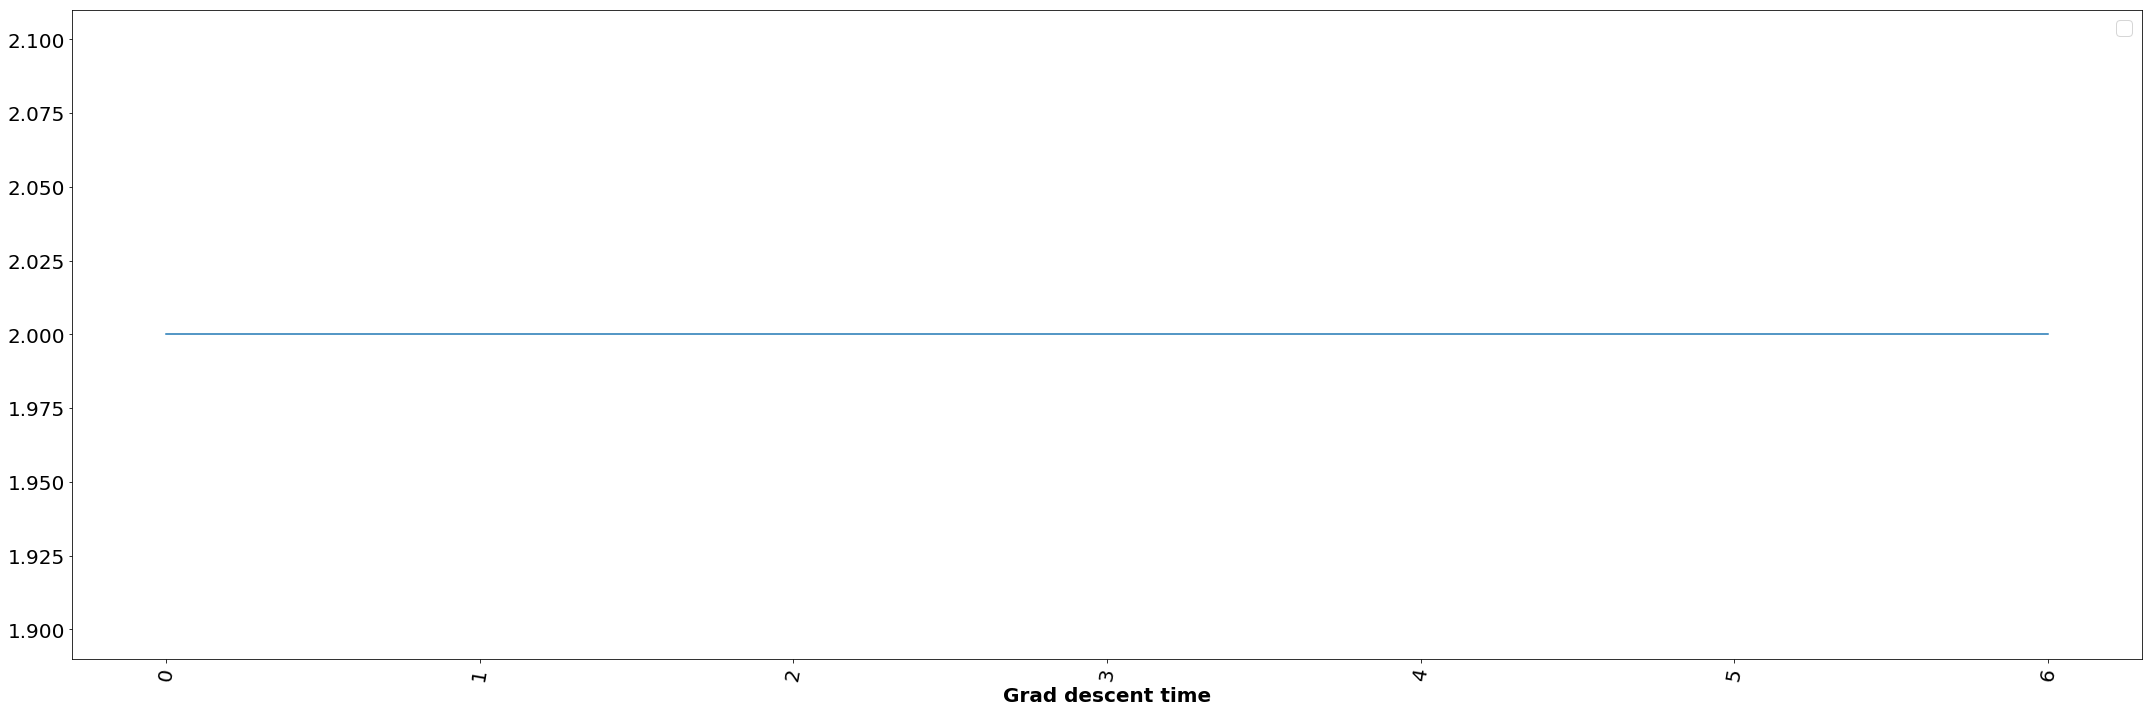

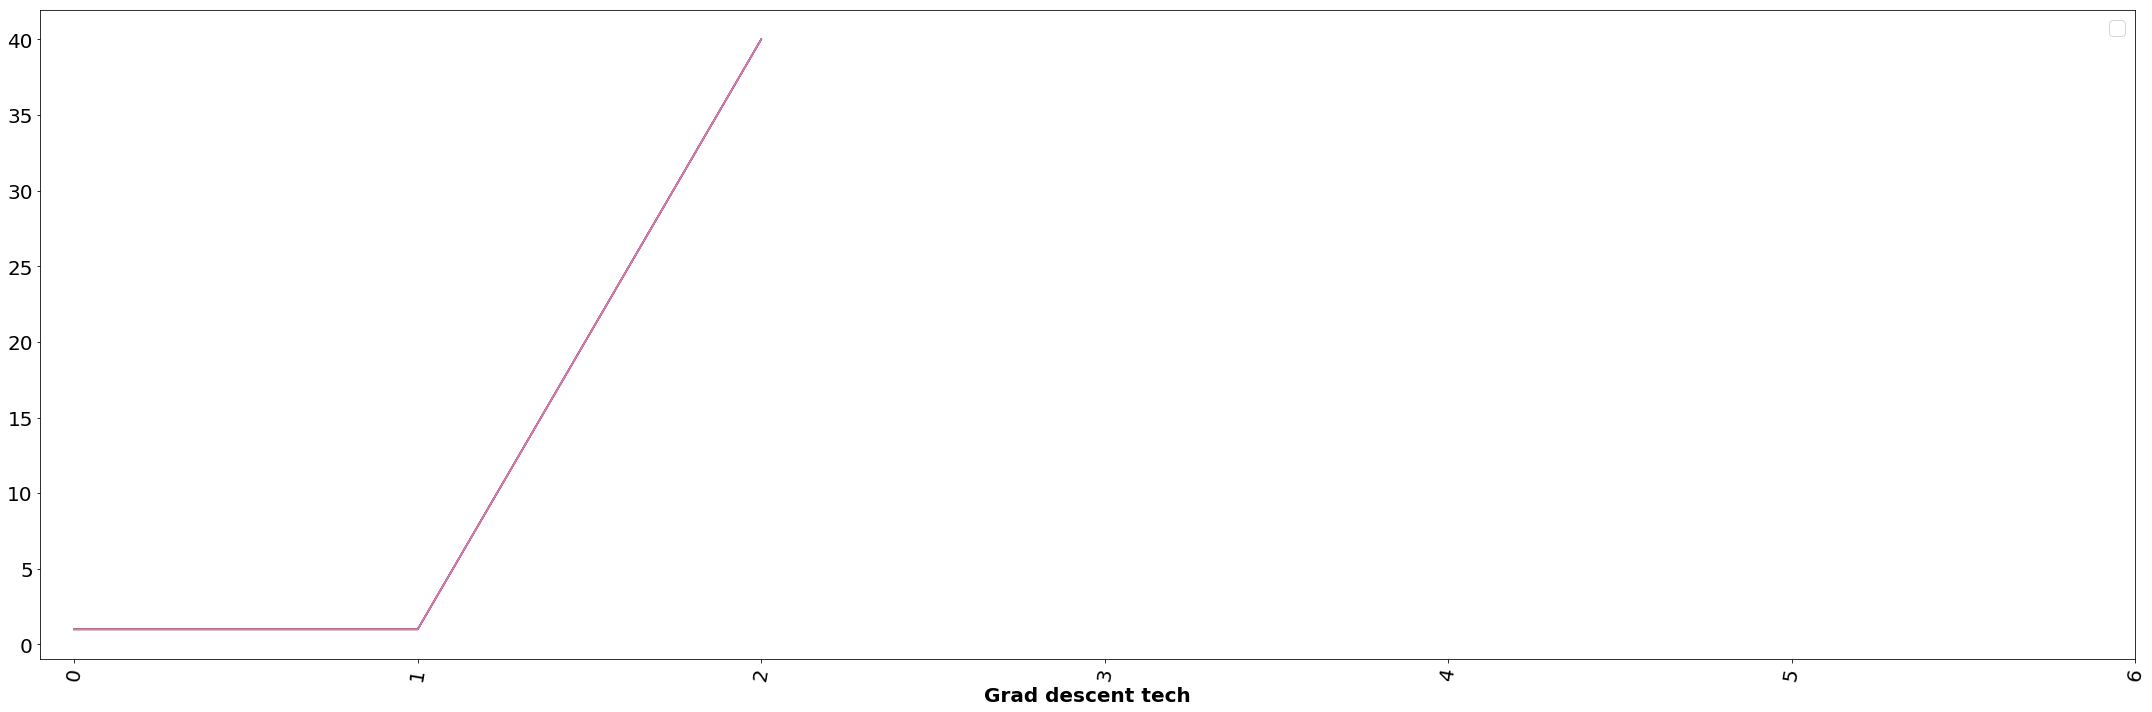

In [15]:
scheduler = Scheduling()
time_list, bandwidth_time_list, mem_size_idle_time_list, bank_list, mem_size_list, compute_list, tech_params = runner([vgg11_graph], scheduler)
plot_descent(time_list, bandwidth_time_list, mem_size_idle_time_list)
print(tech_params)
# Plot Design Parameters change over time
plot_design_param_change(bank_list, mem_size_list, compute_list)
# Plot Technology Parameters change over time
plot_tech_param_change(np.transpose(np.array(tech_params)))

## Multiple Sweep Memory Banks/Connectivity

Time 5704672 0 0 820023
Energy 2055349932 2040767292 12606149 10079755 1422368 5315754 0 5704672
memory accesses 330234742 330234742 5704672 265787728
Design Params 2 1030071 1000 0.0381733
Tech Params [1, 1, 40]
Time 5434890 9698 0 1304785
Energy 1735203806 1721473299 6303074 5039877 1355103 2657877 0 5434890
memory accesses 165117371 165117371 5434890 132893864
Design Params 2 1032945 1000 0.0381733
Tech Params [1, 1, 40]
Time 5434890 9698 0 1304785
Energy 1735203806 1721473299 6303074 5039877 1355103 2657877 0 5434890
memory accesses 165117371 165117371 5434890 132893864
Design Params 2 1037746 1000 0.0381733
Tech Params [1, 1, 40]
Time 5434890 9698 0 1304785
Energy 1735203806 1721473299 6303074 5039877 1355103 2657877 0 5434890
memory accesses 165117371 165117371 5434890 132893864
Design Params 2 1042547 1000 0.0381733
Tech Params [1, 1, 40]
Time 5434890 9698 0 1304785
Energy 1735203806 1721473299 6303074 5039877 1355103 2657877 0 5434890
memory accesses 165117371 165117371 5434890

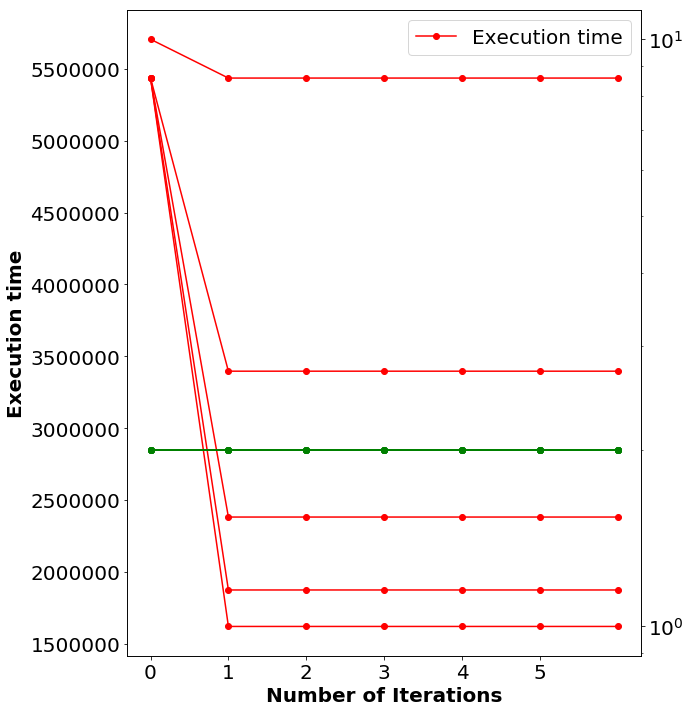

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax2 = ax.twinx()
base_dir = "figures/"
error_config = {"ecolor": "0.3"}
index = np.arange(6)
j=0
scheduler.config["memory"]["level1"]["frequency"]=5
scheduler.config["memory"]["level1"]["frequency"]*=2**j
time_list, bandwidth_time_list,_,bank_list,_,_,_= runner([vgg11_graph],scheduler)
plot_time_descent_multiple(ax, time_list, bandwidth_time_list, time_list_label="Execution time")
plot_parameter_change_multiple(ax2, bank_list)
for j in range(1,5):
    scheduler = Scheduling()
    scheduler.config["memory"]["level1"]["frequency"]=5
    scheduler.config["memory"]["level1"]["frequency"]*=2**j
    time_list, bandwidth_time_list,_,bank_list,_,_,_= runner([vgg11_graph],scheduler)
    plot_time_descent_multiple(ax, time_list, bandwidth_time_list)
    plot_parameter_change_multiple(ax2, bank_list)
ax.legend(fontsize=20)
ax.set_xticks(index)
plt.xticks(rotation=80)
plt.rc("xtick", labelsize=20)  # fontsize of the tick labels
plt.rc("ytick", labelsize=20)
ax.set_ylabel("Execution time", fontsize=20, fontweight="bold")
ax2.set_ylabel("External Memory Connectivity", fontsize=20, fontweight="bold")
ax.set_xlabel("Number of Iterations", fontsize=20, fontweight="bold")
ax2.set_ylabel("")
fig.tight_layout()
plt.yscale("log")
plt.savefig(base_dir + "multiple_bandwidth.png", bbox_inches="tight")
plt.show()

## Multiple Sweep Memory Size

Time 5434890 9698 0 1304785
Energy 1735203806 1721473299 6303074 5039877 1355103 2657877 0 5434890
memory accesses 165117371 165117371 5434890 132893864
Design Params 2 316.22776601683796 1000 0.0381733
Tech Params [1, 1, 40]
Time 18630882 9698 0 2028873
Energy 6932429126 6932135015 315421 401418 22059 2657877 0 18630882
memory accesses 165863867 165863867 18630882 132893864
Design Params 2 5117.227766016838 1000 0.00190169
Tech Params [1, 1, 40]
Time 16121654 9698 0 1764337
Energy 5994585055 5994320655 315421 401418 19088 2657877 0 16121654
memory accesses 165863867 165863867 16121654 132893864
Design Params 2 7294.227766016838 1000 0.00190169
Tech Params [1, 1, 40]
Time 13293723 9698 0 1639826
Energy 4865084319 4864853406 315406 401398 15740 2657877 0 13293723
memory accesses 165855675 165855675 13293723 132893864
Design Params 2 9482.227766016838 1000 0.00190169
Tech Params [1, 1, 40]
Time 12570908 9698 0 1557566
Energy 4597457006 4597234651 315406 401398 14884 2657877 0 12570908
me

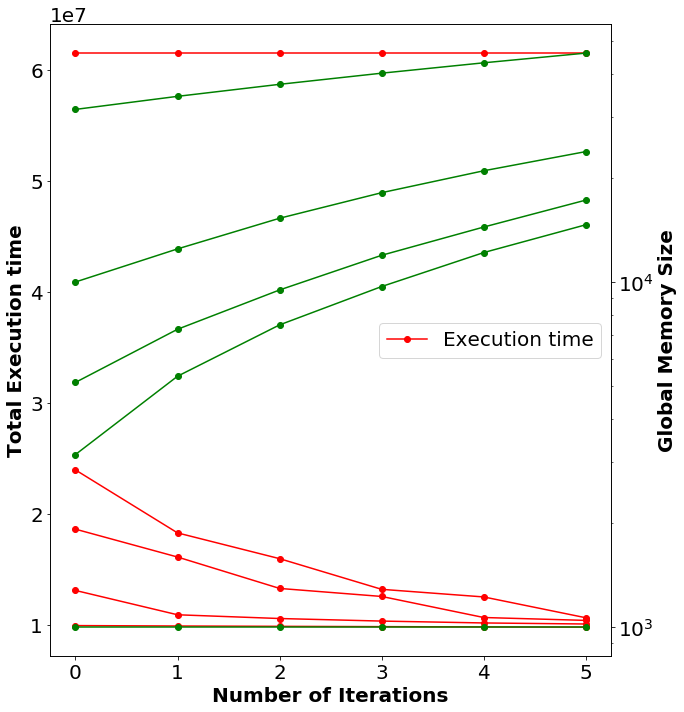

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax2 = ax.twinx()
base_dir = "figures/"
error_config = {"ecolor": "0.3"}
index = np.arange(6)
scheduler = Scheduling()
i=5
scheduler.config["memory"]["level0"]["size"]=10**(i/2)
time_list, bandwidth_time_list,mem_size_idle_time_list, bank_list, mem_size_list, compute_list,_ = runner([vgg11_graph],scheduler)
plot_time_descent_multiple(ax, time_list, mem_size_idle_time_list, time_list_label="Execution time", descent_list_label="Gradient Descent")
plot_parameter_change_multiple(ax2, mem_size_list, parameter_label = "Global Memory Size")
for i in range(6,10):
    scheduler.config["memory"]["level0"]["size"]=10**(i/2)
    time_list, bandwidth_time_list,mem_size_idle_time_list, bank_list, mem_size_list, compute_list,_ = runner([vgg11_graph],scheduler)
    plot_time_descent_multiple(ax, time_list, mem_size_idle_time_list)
    plot_parameter_change_multiple(ax2, mem_size_list)
ax.legend(fontsize=20)
ax.set_xticks(index)
plt.xticks(rotation=80)
plt.rc("xtick", labelsize=20)  # fontsize of the tick labels
plt.rc("ytick", labelsize=20)
ax.set_ylabel("Total Execution time", fontsize=20, fontweight="bold")
ax2.set_ylabel("Global Memory Size", fontsize=20, fontweight="bold")
ax.set_xlabel("Number of Iterations", fontsize=20, fontweight="bold")
fig.tight_layout()
plt.yscale("log")
plt.savefig(base_dir + "memory_size_multiple.png", bbox_inches="tight")
plt.show()

# Technology Tables

In [116]:
import numpy as np
import pandas as pd
d = pd.read_csv('tables/sram.csv')
a = np.array(d)

input = a[:,:3]
# output = a[:,3:]


In [53]:
d = pd.read_csv('plugins/cacti/bus_width.out')


d = d.drop(d.columns[[0,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]], axis=1)

d = d.drop(' Associativity',1)
d = d.drop(' Dynamic search energy (nJ)',1)

In [55]:
a= np.array(d)
np.savetxt('bus.csv',a, fmt='%.18e', delimiter=',')



In [ ]:
bar_graph("read_dummy.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)


In [232]:
mem_table = np.array(pd.read_csv("tables/sram.csv", header=None))
a = mem_table[np.where(mem_table[:, 1] == 4)]
a = a[np.where(a[:, 2] == 32)]

compute:
    name       : MACs
        class      : mac
        attributes :            
        instances       : 256
        meshX           : 16
        word-bits       : 16

    memory: 
        name       : DRAM
        class      : DRAM
        attributes :
        instances       : 1
        word-bits       : 16
  
    name       : OutputBuffer
        class      : SRAM
        attributes :
        entries         : 1024  # 64 * 16 = 1024
        instances       : 1
        meshX           : 1
        word-bits       : 16
        block-size      : 16
        read_bandwidth  : 16 # words/cycle
        write_bandwidth : 16 # words/cycle

        name       : InputBuffer
            class      : SRAM
            attributes :
            entries         : 1024 # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        name       : PsumRegFile
            class      : regfile
            attributes :
            entries         : 1
            instances       : 16
            meshX           : 16
            word-bits       : 16
            cluster-size    : 16
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
            
        name       : WeightBuffer
            class      : regfile
            attributes :
            entries         : 64
            instances       : 256
            meshX           : 16
            word-bits       : 16
            cluster-size    : 256
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
    noc:



In [4]:
from dot import *

In [ ]:
dot_rep = make_graph_from_trace()